In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [30]:
def generate_data(k, n_samples=1000, noise_std=0.05):
    # Each of the k categories is mapped to [cos(theta), sin(theta)]

    categories = np.random.randint(0, k, size=n_samples)
    thetas = 2 * np.pi * categories / k
    noises = [np.random.normal(0, noise_std, size=n_samples) for _ in range(2)]
    # Add small noise around each point
    X = np.stack([np.cos(thetas+noises[0]), np.sin(thetas+noises[1])], axis=1)
    Y = categories
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.long)

class SimpleNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNet, self).__init__()
        self.fc_1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.to_out = nn.Linear(128, output_dim)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.to_out(x)
        return x

def train_model(model, dataloader, steps = 1000, lr=1e-3, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    loader_iter = iter(dataloader)
    for _ in range(steps):
        x,y = next(loader_iter)
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()


def accuracy(model, dataloader, device='cpu'):
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            _, predicted = torch.max(logits, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return correct/total

# define a dataset from tensor and a simple dataloader
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]



In [39]:
# ks = [16, 32, 64, 96, 128, 160, 192, 224, 256]
# ks = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]
# ks = [8, 32, 64, 128, 256, 512]
ks = [128]

device = 'cuda'
# noise_stds = [0, 0.01, 0.03, 0.07]
noise_stds = [0]
accuracies = [[] for _ in noise_stds]
for i,noise_std in enumerate(noise_stds):
    print(f"Training with noise std={noise_std}")
    for k in ks:
        X, Y = generate_data(k, n_samples = int(1e6), noise_std=noise_std)
        dataset = Dataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        model = SimpleNet(input_dim=2, output_dim=k).to(device)
        train_model(model, dataloader, steps=5000, device=device)
        X, Y = generate_data(k, n_samples = int(1e4), noise_std=noise_std)
        eval_dataset = Dataset(X, Y)
        eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=128, shuffle=False)
        acc = accuracy(model, eval_dataloader, device=device)
        accuracies[i].append(acc)
        print(f"K={k}, Accuracy={acc:.4f}")

Training with noise std=0


K=128, Accuracy=1.0000


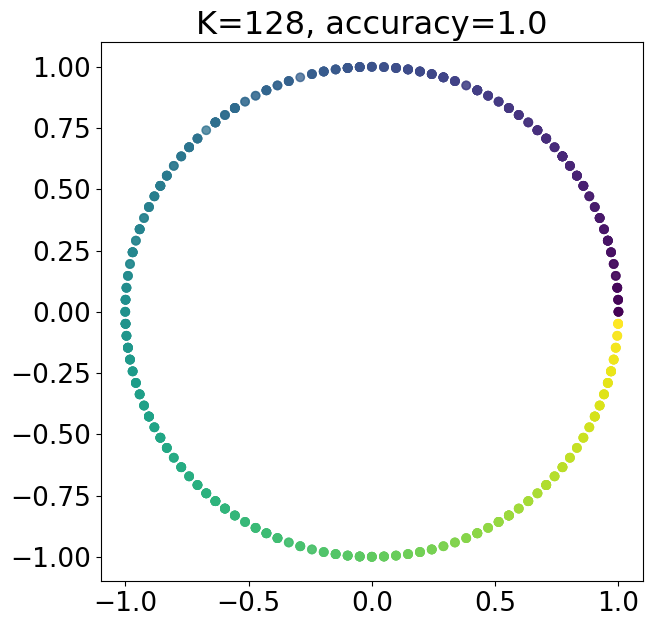

In [40]:
samples = 1000
fig, ax = plt.subplots(figsize=(7, 7))  # Single plot

# Choose the index of k and corresponding accuracy to plot
i = 0  # Change this index to plot a different k
x, y = generate_data(ks[i], samples, noise_stds[0])
ax.scatter(x[:, 0], x[:, 1], c=y, alpha=0.5)
ax.set_title(f"K={ks[i]}, accuracy={accuracies[0][i]:.1f}", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=19)
plt.savefig(f'circle_sep.pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)

plt.show()

In [40]:
# ks = [16, 32, 64, 96, 128, 160, 192, 224, 256]
ks = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]
# ks = [8, 32, 64, 128, 256, 512]

device = 'cuda'
# noise_stds = [0, 0.01, 0.03, 0.07]
noise_stds = [0]
accuracies = [[] for _ in noise_stds]
for i,noise_std in enumerate(noise_stds):
    print(f"Training with noise std={noise_std}")
    for k in ks:
        X, Y = generate_data(k, n_samples = int(1e6), noise_std=noise_std)
        dataset = Dataset(X, Y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        model = SimpleNet(input_dim=2, output_dim=k).to(device)
        train_model(model, dataloader, steps=5000, device=device)
        X, Y = generate_data(k, n_samples = int(1e4), noise_std=noise_std)
        eval_dataset = Dataset(X, Y)
        eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=128, shuffle=False)
        acc = accuracy(model, eval_dataloader, device=device)
        accuracies[i].append(acc)
        print(f"K={k}, Accuracy={acc:.4f}")


Training with noise std=0
K=16, Accuracy=1.0000
K=32, Accuracy=1.0000
K=48, Accuracy=1.0000
K=64, Accuracy=1.0000
K=80, Accuracy=1.0000
K=96, Accuracy=1.0000
K=112, Accuracy=1.0000
K=128, Accuracy=1.0000
K=144, Accuracy=0.9874
K=160, Accuracy=0.9523
K=176, Accuracy=0.8653
K=192, Accuracy=0.8408
K=208, Accuracy=0.8184
K=224, Accuracy=0.7946
K=240, Accuracy=0.7000
K=256, Accuracy=0.6569


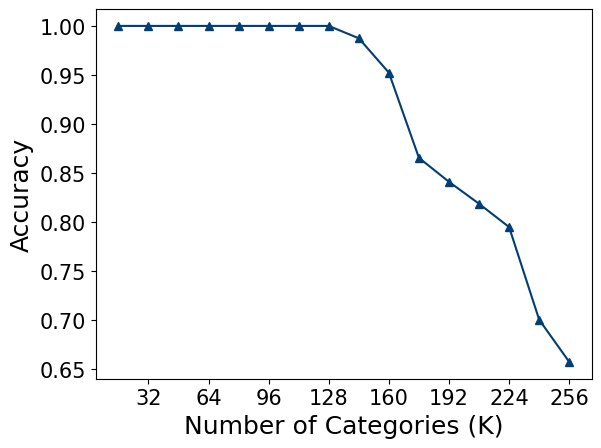

In [55]:
# Select only values of ks that are divisible by 32 for the x-ticks
x_ticks = [k for k in ks if k % 32 == 0]

# Normalize the RGB values to [0, 1]
color_rgb = (0/255, 62/255, 116/255)

plt.figure()
for i in range(len(noise_stds)):
    plt.plot(ks, accuracies[i], marker='^', label=f"noise_std={noise_stds[i]}", color=color_rgb)

plt.xticks(x_ticks, labels=[str(k) for k in x_ticks], fontsize=15)  # Set x-ticks only at values divisible by 32
plt.yticks(fontsize=15)

plt.xlabel("Number of Categories (K)", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
# plt.xscale("log")  # Uncomment this line if you want log scale

plt.savefig('catconverter_ablation.pdf', dpi=300, bbox_inches='tight', pad_inches=0.01)
plt.show()